# Surnjani Djoko
# Dec 9, 2021
# Use XGBoost for binary classification

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import xgboost as xgb
    # xgboost can't take categorical variable (only lgbm)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# define KS statistics
def ks(data=None,target=None, prob=None):
    
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + \
                  str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [3]:
# binary classification metrics
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred): 
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [4]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References: 
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix
    
    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)
    
    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive
    
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)
    
    positive = tp + fn
    negative = tn + fp
    
    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn
    
    metrics['Positive'] = positive
    metrics['Negative'] = negative
    
    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive
        
    metrics['Recall'] = recall
    
    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr
    
    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision
    
    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy
    
    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr
    
    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr
    
    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:        
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1
    
    return metrics

In [5]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [94]:
train = pd.read_csv('data/final_train.csv')
print(train.shape)
test = pd.read_csv('data/final_test.csv')
print(test.shape)

(14028, 77)
(3508, 77)


In [7]:
display(train.sample(3))
list(train.columns)

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed,DISTANCE_INCIDENT_FIRESTATION_imputed,Property_Use_imputed,Estimated_Dollar_Loss_imputed,Level_Of_Origin_impute,Level_Of_Origin_encoded,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_imputed,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe,Smoke_Spread_imputed,Smoke_Spread_woe,Level_Of_Origin_encoded_imputed,Level_Of_Origin_encoded_woe,Extent_Of_Fire_imputed,Extent_Of_Fire_woe,t0,t1,t2,t3,t4
5532,81 - Engine Area,08 - Not Applicable,8 - Not applicable (not a business),0,0,20000.0,NaN,NaN,"02 - Explosion (including during Fire, excludi...",Not applicable,8 - Not applicable (no system),2 - No Fire alarm system,999 - Undetermined,F13034398,VEF,NaN,47 - Vehicle,1 - Extinguished by fire department,1,4,51 - Mechanical Failure,901 - Automobile,Not applicable,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,Not applicable,Not applicable,8 - Not applicable - no sprinkler system present,9 - Undetermined,"7 - Fully involved (total structure, vehicle, ...",0,0,13677.797818,0,0,5,6.383,40.167,5,0,0,0,0,2.30,0.00,0.0,11.460,63.145,16.135,M1B,1764.25,0.055844,0.275266,38.9,38.2,0.478369,28.868334,17.0,28.868334,13677.797818,901 - Automobile,20000.0,999,below_grade_level,Not applicable,-2.197231,Not applicable,-2.197231,below_grade_level,-0.893688,8 - Entire Structure,-1.515563,0.050008,0.799931,0.050058,0.050002,0.050001
3101,46 - Product Storage (inc products or material...,01 - Normal (no change),1 - No business interruption,0,0,100000.0,0.0,1 - Confined to object of origin,01 - Fire,9 - Undetermined,9 - Fire alarm system operation undetermined,1 - Fire alarm system present,999 - Undetermined,F14053644,FACI,001,55 - Wood,1 - Extinguished by fire department,17,54,"98 - Unintentional, cause undetermined",759 - Sto: Other Metal/Electrical/Misc Parts,4 - Floor/suite of fire origin: Smoke alarm pr...,4 - Remote from fire – smoke did not reach alarm,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",8 - Entire Structure,1 - Sprinkler system activated,1 - Full sprinkler system present,2 - Fire with no evidence from street,0,0,13708.324804,6,1,6,4.083,122.700,5,0,0,0,0,2.41,0.00,0.0,19.985,67.410,14.225,M9W,1411.27,0.066034,0.175848,39.6,38.3,0.490844,33.295294,0.0,33.295294,13708.324804,759 - Sto: Other Metal/Electrical/Misc Parts,100000.0,001,low_rise_level,"8 - Not applicable: No alarm, no persons present",-1.142621,8 - Entire Structure,0.769229,low_rise_level,0.365566,1 - Confined to object of origin,-0.191537,0.028906,0.028624,0.885175,0.028607,0.028688
3527,"12 - Hallway, Corridor",01 - Normal (no change),1 - No business interruption,0,0,200.0,1.0,1 - Confined to object of origin,01 - Fire,1 - All persons (at risk of injury) evacuated ...,1 - Fire ala

['Area_of_Origin',
 'Building_Status',
 'Business_Impact',
 'Civilian_Casualties',
 'Count_of_Persons_Rescued',
 'Estimated_Dollar_Loss',
 'Estimated_Number_Of_Persons_Displaced',
 'Extent_Of_Fire',
 'Final_Incident_Type',
 'Fire_Alarm_System_Impact_on_Evacuation',
 'Fire_Alarm_System_Operation',
 'Fire_Alarm_System_Presence',
 'Ignition_Source',
 'Incident_Numberinc_',
 'Initial_CAD_Event_Type',
 'Level_Of_Origin',
 'Material_First_Ignited',
 'Method_Of_Fire_Control',
 'Number_of_responding_apparatus',
 'Number_of_responding_personnel',
 'Possible_Cause',
 'Property_Use',
 'Smoke_Alarm_at_Fire_Origin',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
 'Smoke_Spread',
 'Sprinkler_System_Operation',
 'Sprinkler_System_Presence',
 'Status_of_Fire_On_Arrival',
 'TFS_Firefighter_Casualties',
 'LABEL',
 'DISTANCE_INCIDENT_FIRESTATION',
 'DOW',
 'IS_WEEKEND',
 'MONTH',
 'MINUTES_TO_ARRIVE'

In [95]:
# new list!!
keep_cols = ['LABEL','Count_of_Persons_Rescued','Number_of_responding_apparatus','Number_of_responding_personnel',
            'MINUTES_TO_ARRIVE','MINUTES_TO_LEAVE',
 'rain_v','temperature_avg',
 'relative_humidity_avg','wind_speed_avg','density',
 'poor_building_condition','condo_dwelling','Average_Age',
'male', 'Estimated_Number_Of_Persons_Displaced_imputed',
 'min_dist_to_hydrant_imputed','DISTANCE_INCIDENT_FIRESTATION_imputed',
 #'Property_Use_imputed',
 'Estimated_Dollar_Loss_imputed',
 #'Level_Of_Origin_encoded',
# 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_imputed',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe',
# 'Smoke_Spread_imputed',
 'Smoke_Spread_woe',
# 'Level_Of_Origin_encoded_imputed',
# 'Extent_Of_Fire_imputed',
 'Extent_Of_Fire_woe','t0','t1','t2','t3','t4']

In [96]:
train_1 = train[keep_cols]
test_1 = test[keep_cols]
test_1.shape

(3508, 27)

In [10]:
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [11]:
find_diff_type_var(train_1)

<ipython-input-10-60a1476e4fd3>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_var = df.loc[:,df.dtypes == np.object].columns
<ipython-input-10-60a1476e4fd3>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_var = df.loc[:,df.dtypes != np.object].columns


(Index([], dtype='object'),
 Index(['LABEL', 'Count_of_Persons_Rescued', 'Number_of_responding_apparatus',
        'Number_of_responding_personnel', 'MINUTES_TO_ARRIVE',
        'MINUTES_TO_LEAVE', 'rain_v', 'temperature_avg',
        'relative_humidity_avg', 'wind_speed_avg', 'density',
        'poor_building_condition', 'condo_dwelling', 'Average_Age', 'male',
        'Estimated_Number_Of_Persons_Displaced_imputed',
        'min_dist_to_hydrant_imputed', 'DISTANCE_INCIDENT_FIRESTATION_imputed',
        'Estimated_Dollar_Loss_imputed',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe',
        'Smoke_Spread_woe', 'Extent_Of_Fire_woe', 't0', 't1', 't2', 't3', 't4'],
       dtype='object'))

In [12]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14028 entries, 0 to 14027
Data columns (total 27 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   LABEL                                                              14028 non-null  int64  
 1   Count_of_Persons_Rescued                                           14028 non-null  int64  
 2   Number_of_responding_apparatus                                     14028 non-null  int64  
 3   Number_of_responding_personnel                                     14028 non-null  int64  
 4   MINUTES_TO_ARRIVE                                                  14028 non-null  float64
 5   MINUTES_TO_LEAVE                                                   14028 non-null  float64
 6   rain_v                                                             14028 non-null  float64
 7   temperature_avg       

In [97]:
# no need to split the train, will be done in hyperparameter tuning ....
X = train_1.drop(columns='LABEL')
y = train_1['LABEL']
#X_train_2, X_valid, y_train_2, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
#print(X_train.shape)
#X_valid.shape
X_test = test_1.drop(columns='LABEL')
y_test = test_1['LABEL']

# Modeling

In [65]:
from sklearn.model_selection import GridSearchCV

#XGBoost hyper-parameter tuning
def hyperParameterTuning_weight(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5], # not sure what this is!!
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ["binary:logistic"], 
        'scale_pos_weight': [10,25,50,75,99] # for unbalance data
            # default is 1
    }

    xgb_model = xgb.XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch

# run this to return the best parameters ....
gsearch_weight = hyperParameterTuning_weight(X, y)
# print the best hyperparameters
print(gsearch_weight.best_params_)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:33:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'binary:logistic', 'scale_pos_weight': 10, 'subsample': 0.7}


In [66]:
# best estimator
gsearch_weight.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
gsearch_weight.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'binary:logistic',
 'scale_pos_weight': 10,
 'subsample': 0.7}

In [15]:
# use the returned best parameters to do the best fit (gsearch.best_params_)
xgb_model_weight = xgb.XGBClassifier(
        objective = "binary:logistic",
        colsample_bytree = 0.7,
        learning_rate = 0.01,
        max_depth = 10,
        min_child_weight = 1,
        n_estimators = 500,
        subsample = 0.5,
        scale_pos_weight = 10)

In [16]:
# fit the model
%time xgb_model_weight.fit(X, y, verbose=True)

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:22:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 6s, sys: 1.3 s, total: 1min 7s
Wall time: 4.62 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
# save model
xgb_model_weight.save_model("my_best_xgb_model_weight.model")
# load model
'''
loaded_model = xgb.Booster()
loaded_model.load_model("my_best_xgb_model.model")
# use it to predict
loaded_model.predict(...)
'''

'\nloaded_model = xgb.Booster()\nloaded_model.load_model("my_best_xgb_model.model")\n# use it to predict\nloaded_model.predict(...)\n'

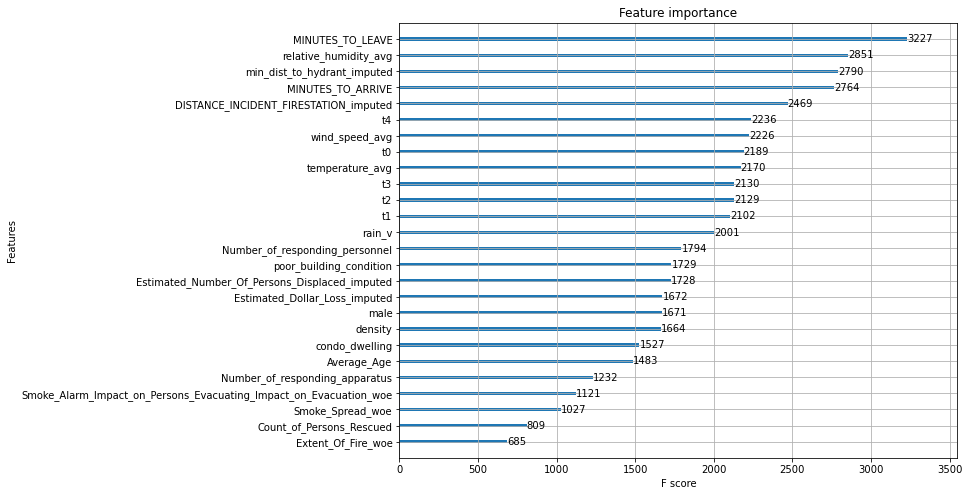

In [17]:
# plot the feature importance
fig, ax = plt.subplots(figsize = (10, 8))
xgb.plot_importance(xgb_model_weight, ax=ax)
plt.show()

In [20]:
# perform prediction on testing
y_pred_xgb = xgb_model_weight.predict(X_test)
    
test_1['predicted_class'] = y_pred_xgb
#logloss_xgb = mean_absolute_error(y_test, y_pred_xgb)
#print("MAE: ", mae_xgb)

<ipython-input-20-ce279a0978cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['predicted_class'] = y_pred_xgb


In [21]:
test_1['predicted_prob'] = xgb_model_weight.predict_proba(X_test)[:,1]
    # take the 2nd column for class 1 prediction (with casualties)
    # because in ROC curve are defined in terms of the positive class (class 1)

<ipython-input-21-e023d611eb99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['predicted_prob'] = xgb_model_weight.predict_proba(X_test)[:,1]


In [31]:
# perform prediction on training
train_1['predicted_class'] = xgb_model_weight.predict(X)
train_1['predicted_prob'] = xgb_model_weight.predict_proba(X)[:,1]

<ipython-input-31-861b1904f5c0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-861b1904f5c0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Evaluation

### (1) Confusion matrix 

In [32]:
# testing
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_1['LABEL'], test_1['predicted_class'],labels=[1,0])

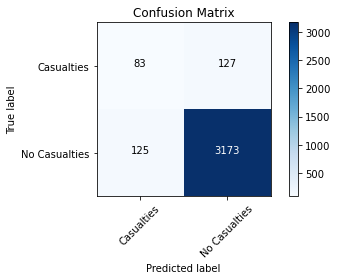

In [75]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Casualties','No Casualties'],
                      title='Confusion Matrix')

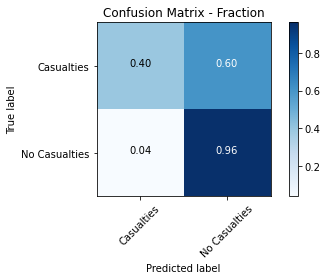

In [76]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Casualties','No Casualties'],
                      title='Confusion Matrix - Fraction', normalize=True)

In [77]:
metrics = [binary_classifier_metrics(test_1['LABEL'], test_1['predicted_class'])]
df_metrics=pd.DataFrame.from_dict(metrics)
df_metrics.index = ['Model']

In [78]:
df_metrics

,TruePositive,TrueNegative,FalsePositive,FalseNegative,Positive,Negative,Recall,TrueNegativeRate,Precision,Accuracy,FalsePositiveRate,FalseNegativeRate,F1
Model,83,3173,125,127,210,3298,0.395238,0.962098,0.399038,0.928164,0.037902,0.604762,0.397129


In [79]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

Counts
       TruePositive  FalseNegative  FalsePositive  TrueNegative
Model            83            127            125          3173

Fractions
       Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model     0.4                0.6               0.04              0.96

       Precision  Accuracy   F1
Model        0.4      0.93  0.4


In [80]:
print(classification_report(
    test_1['LABEL'],
    test_1['predicted_class'],
    labels=[1,0],
    target_names=['Casualties','No Casualties']))

               precision    recall  f1-score   support

   Casualties       0.40      0.40      0.40       210
No Casualties       0.96      0.96      0.96      3298

     accuracy                           0.93      3508
    macro avg       0.68      0.68      0.68      3508
 weighted avg       0.93      0.93      0.93      3508



In [90]:
test_1.sample(3)

,LABEL,Count_of_Persons_Rescued,Number_of_responding_apparatus,Number_of_responding_personnel,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,rain_v,temperature_avg,relative_humidity_avg,wind_speed_avg,density,poor_building_condition,condo_dwelling,Average_Age,male,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed,DISTANCE_INCIDENT_FIRESTATION_imputed,Estimated_Dollar_Loss_imputed,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe,Smoke_Spread_woe,Extent_Of_Fire_woe,t0,t1,t2,t3,t4,predicted_class,predicted_prob
3404,0,0,5,17,5.783,20.367,2.39,18.175,71.550,13.22,4691.35,0.094549,0.109606,40.3,0.491090,0.0,11.794417,13691.711135,200.0,-1.142621,-0.444676,-0.191537,0.028572,0.028571,0.885644,0.028603,0.028610,0,0.030640
1316,1,0,5,17,4.933,134.300,2.25,19.510,70.775,12.76,8005.59,0.096534,0.042862,41.8,0.475144,15.0,27.033903,13689.599082,15000.0,-2.197231,-2.197231,-1.515563,0.066675,0.733139,0.066848,0.066669,0.066669,1,0.766868
2364,0,0,6,21,4.350,3.933,2.69,17.565,66.520,15.07,20466.15,0.040702,0.573736,36.6,0.527962,17.0,9.876069,13681.654808,4110.0,-2.197231,-2.197231,-1.515563,0.885704,0.028572,0.028580,0.028572,0.028572,0,0.005875


In [35]:
train_1.sample(3)

,LABEL,Count_of_Persons_Rescued,Number_of_responding_apparatus,Number_of_responding_personnel,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,rain_v,temperature_avg,relative_humidity_avg,wind_speed_avg,density,poor_building_condition,condo_dwelling,Average_Age,male,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed,DISTANCE_INCIDENT_FIRESTATION_imputed,Estimated_Dollar_Loss_imputed,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe,Smoke_Spread_woe,Extent_Of_Fire_woe,t0,t1,t2,t3,t4,predicted_class,predicted_prob
11474,1,2,19,52,6.450,794.767,1.07,-3.760,71.990,17.990,1411.27,0.066034,0.175848,39.6,0.490844,6.0,46.750236,13709.956257,25000.0,0.557903,0.679226,0.644495,0.014300,0.014316,0.434010,0.014367,0.523007,1,0.942835
9673,0,0,1,4,7.433,76.767,0.98,-3.020,71.400,17.735,3610.31,0.088820,0.275155,40.4,0.435258,17.0,34.207417,13694.870792,1000.0,-2.197231,-2.197231,-1.515563,0.070144,0.719223,0.071447,0.067870,0.071317,0,0.007840
13678,0,0,8,23,6.900,99.650,1.12,-3.315,77.325,18.370,3341.63,0.069343,0.230922,43.2,0.468746,0.0,43.614082,13700.287318,100000.0,-1.142621,-0.444676,-0.191537,0.317940,0.579905,0.033743,0.033508,0.034905,0,0.035864


Counts
       TruePositive  FalseNegative  FalsePositive  TrueNegative
Model           782              1            211         13034

Fractions
       Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model     1.0                0.0               0.02              0.98

       Precision  Accuracy    F1
Model       0.79      0.98  0.88
               precision    recall  f1-score   support

   Casualties       0.79      1.00      0.88       783
No Casualties       1.00      0.98      0.99     13245

     accuracy                           0.98     14028
    macro avg       0.89      0.99      0.94     14028
 weighted avg       0.99      0.98      0.99     14028



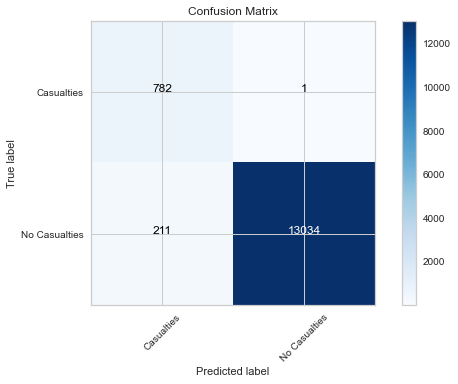

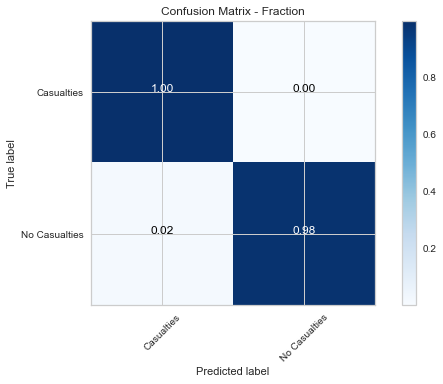

In [61]:
# training
cnf_matrix_train = confusion_matrix(train_1['LABEL'], train_1['predicted_class'],labels=[1,0])
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_train, classes=['Casualties','No Casualties'],
                      title='Confusion Matrix')
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_train, classes=['Casualties','No Casualties'],
                      title='Confusion Matrix - Fraction', normalize=True)

metrics_train = [binary_classifier_metrics(train_1['LABEL'], train_1['predicted_class'])]
df_metrics_train=pd.DataFrame.from_dict(metrics_train)
df_metrics_train.index = ['Model']

print('Counts')
print(df_metrics_train[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics_train[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics_train[['Precision',
                  'Accuracy',
                  'F1']].round(2))

print(classification_report(
    train_1['LABEL'],
    train_1['predicted_class'],
    labels=[1,0],
    target_names=['Casualties','No Casualties']))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

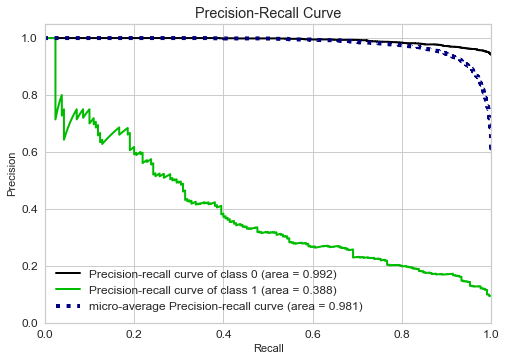

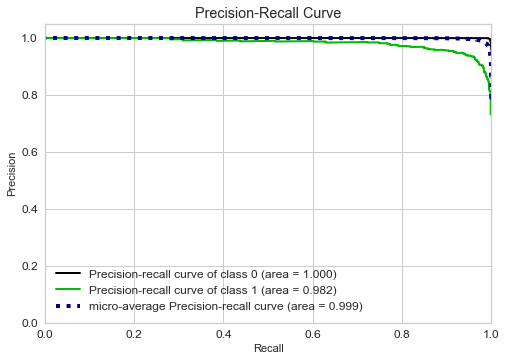

In [92]:
# precision recall chart
skplt.metrics.plot_precision_recall(test_1['LABEL'], xgb_model_weight.predict_proba(X_test))

skplt.metrics.plot_precision_recall(train_1['LABEL'], xgb_model_weight.predict_proba(X))

### (2) KS statistics evaluation

In [86]:
def ks(data=None,target=None, prob=None):
    
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

my_ks = ks(data=test_1, target='LABEL', prob='predicted_prob')
my_ks

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.373721  0.962998     109        242     51.90%         7.34%   
2       0.202966  0.372508      48        303     22.86%         9.19%   
3       0.121978  0.202422      25        326     11.90%         9.88%   
4       0.068683  0.121956      18        332      8.57%        10.07%   
5       0.037425  0.068584       7        344      3.33%        10.43%   
6       0.019148  0.037242       2        349      0.95%        10.58%   
7       0.007556  0.019080       1        349      0.48%        10.58%   
8       0.006100  0.007556       0        351      0.00%        10.64%   
9       0.004971  0.006098       0        351      0.00%        10.64%   
10      0.003682  0.004970       0        351      0.00%        10.64%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             51.90

<ipython-input-86-656d56a1f972>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-656d56a1f972>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.373721,0.962998,109,242,51.90%,7.34%,51.90%,7.34%,44.6
2,0.202966,0.372508,48,303,22.86%,9.19%,74.76%,16.53%,58.2
3,0.121978,0.202422,25,326,11.90%,9.88%,86.67%,26.41%,60.3
4,0.068683,0.121956,18,332,8.57%,10.07%,95.24%,36.48%,58.8
5,0.037425,0.068584,7,344,3.33%,10.43%,98.57%,46.91%,51.7
6,0.019148,0.037242,2,349,0.95%,10.58%,99.52%,57.49%,42.0
7,0.007556,0.019080,1,349,0.48%,10.58%,100.00%,68.07%,31.9
8,0.006100,0.007556,0,351,0.00%,10.64%,100.00%,78.71%,21.3
9,0.004971,0.006098,0,351,0.00%,10.64%,100.00%,89.36%,10.6


<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

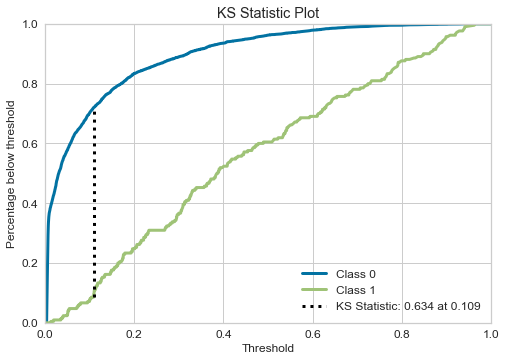

In [87]:
# Do the plotting for testing
skplt.metrics.plot_ks_statistic(test_1['LABEL'], xgb_model_weight.predict_proba(X_test))

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.369645  0.982940     783        620    100.00%         4.68%   
2       0.184237  0.369154       0       1403      0.00%        10.59%   
3       0.103895  0.184218       0       1403      0.00%        10.59%   
4       0.060300  0.103841       0       1402      0.00%        10.59%   
5       0.034668  0.060277       0       1403      0.00%        10.59%   
6       0.017361  0.034658       0       1403      0.00%        10.59%   
7       0.007539  0.017355       0       1402      0.00%        10.59%   
8       0.006069  0.007536       0       1403      0.00%        10.59%   
9       0.004968  0.006068       0       1403      0.00%        10.59%   
10      0.003672  0.004968       0       1403      0.00%        10.59%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1            100.00

<ipython-input-86-656d56a1f972>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-656d56a1f972>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

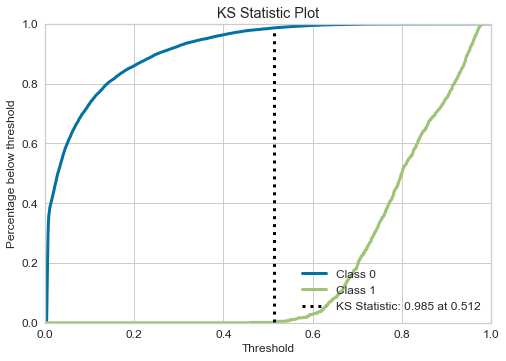

In [89]:
# Do the plotting for training

my_ks_train = ks(data=train_1, target='LABEL', prob='predicted_prob')
my_ks_train

skplt.metrics.plot_ks_statistic(train_1['LABEL'], xgb_model_weight.predict_proba(X))